# RTML Midterm 2022

## Question 1 (20 points)

In Labs 04 and 05, you developed your own PyTorch implementations of YOLOv4 and YOLOR.
Download the image at http://www.cs.ait.ac.th/~mdailey/ait-orientation.jpg and run it
through your YOLOv4 and YOLOR models. Provide your source code to load the model, image,
get the result, and display the result here. Display the resulting bounding boxes.


In [1]:
# utils.py
from __future__ import division

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
import cv2 

def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)
    
    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res


def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    
    
    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    
    return iou

def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):

    
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])
    
    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors
    
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride
    
    return prediction

def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask
    
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = prediction.size(0)

    write = False
    


    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
       #confidence threshholding 
       #NMS
    
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)
        
        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except:
            continue
        
        if image_pred_.shape[0] == 0:
            continue       
#        
  
        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1])  # -1 index holds the class index
        
        
        for cls in img_classes:
            #perform NMS

        
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)   #Number of detections
            
            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
            
                except IndexError:
                    break
            
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       
            
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
                
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class
            
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    try:
        return output
    except:
        return 0
    
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """
    # pylint: disable=no-member
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = letterbox_image(img, (inp_dim, inp_dim))
    return torch.from_numpy(img.transpose(2, 0, 1)).float().div(255.0).unsqueeze(0)

def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names


In [2]:
# darknet.py
from __future__ import division

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np



def get_test_input():
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (608,608))          #Resize to the input dimension
    img_ =  img[:,:,::-1].transpose((2,0,1))  # BGR -> RGB | H X W C -> C X H X W 
    img_ = img_[np.newaxis,:,:,:]/255.0       #Add a channel at 0 (for batch) | Normalise
    img_ = torch.from_numpy(img_).float()     #Convert to float
    img_ = Variable(img_)                     # Convert to Variable
    return img_

def parse_cfg(cfgfile):
    """
    Takes a configuration file
    
    Returns a list of blocks. Each blocks describes a block in the neural
    network to be built. Block is represented as a dictionary in the list
    
    """
    
    file = open(cfgfile, 'r')
    lines = file.read().split('\n')                        # store the lines in a list
    lines = [x for x in lines if len(x) > 0]               # get read of the empty lines 
    lines = [x for x in lines if x[0] != '#']              # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces
    
    block = {}
    blocks = []
    
    for line in lines:
        if line[0] == "[":               # This marks the start of a new block
            if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-init the block
            block["type"] = line[1:-1].rstrip()     
        else:
            key,value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)
    
    return blocks


class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()
        

class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors

class Mish(nn.Module):
     def __init__(self):
         super().__init__()

     def forward(self, x):
         return x * torch.tanh(F.softplus(x))



def create_modules(blocks):
    net_info = blocks[0]     #Captures the information about the input and pre-processing    
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []
    
    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()
    
        #check the type of block
        #create a new module for the block
        #append to module_list
        
        #If it's a convolutional layer
        if (x["type"] == "convolutional"):
            #Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True
        
            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])
        
            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0
        
            #Add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)
        
            #Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)
        
            #Check the activation. 
            #It is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)

            if activation == "mish":
                activn = Mish()
                module.add_module("mish_{0}".format(index), activn)
        
            #If it's an upsampling layer
            #We use Bilinear2dUpsampling
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor = 2, mode = "nearest")
            module.add_module("upsample_{}".format(index), upsample)
                
        #If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            #Start  of a route
            start = int(x["layers"][0])
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            #Positive anotation
            if start > 0: 
                start = start - index
            if end > 0:
                end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]
    
        #shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
            
        #Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]
    
            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]
    
            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)
        
        elif x["type"] == "maxpool":
            stride = int(x["stride"])
            size = int(x["size"])
            assert size % 2
            maxpool = nn.MaxPool2d(kernel_size=size, stride=stride, padding=size // 2)
            module.add_module("maxpool_{0}".format(index), maxpool)
                              
        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)
        
    return (net_info, module_list)

class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_modules(self.blocks)
        
    def forward(self, x, CUDA):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        
        write = 0
        for i, module in enumerate(modules):        
            module_type = (module["type"])
            
            if module_type == "convolutional" or module_type == "upsample" or module_type == "maxpool":
                x = self.module_list[i](x)
                
    
            elif module_type == "route":
                
                # concat layers
                layers = module["layers"]
                layers = [int(a) for a in layers]
                
                if (layers[0]) > 0:
                    layers[0] = layers[0] - i
    
                if len(layers) == 1:    # 1 item in layer                 
                    x = outputs[i + (layers[0])]
    
                else:   # more than 1 item in layer 
                    if len(layers) == 4:       # 4 items in layer                                      
                        if (layers[1]) > 0:
                            layers[1] = layers[1] - i

                        if (layers[2]) > 0:
                            layers[2] = layers[2] - i

                        if (layers[3]) > 0:
                            layers[3] = layers[3] - i

                        map1 = outputs[i + layers[0]]
                        map2 = outputs[i + layers[1]]
                        map3 = outputs[i + layers[2]]
                        map4 = outputs[i + layers[3]]
                        x = torch.cat((map1, map2, map3, map4), 1)

                    else:           # 2 items in layer                
                        if (layers[1]) > 0:
                            layers[1] = layers[1] - i
        
                        map1 = outputs[i + layers[0]]
                        map2 = outputs[i + layers[1]]
                        x = torch.cat((map1, map2), 1)
                
                
            elif module_type == "shortcut":
                from_ = int(module["from"])
                x = outputs[i-1] + outputs[i+from_]
                
    
            elif module_type == 'yolo':        
                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int (self.net_info["height"])
        
                #Get the number of classes
                num_classes = int (module["classes"])
        
                #Transform 
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                if not write:              #if no collector has been intialised. 
                    detections = x
                    write = 1
        
                else:       
                    detections = torch.cat((detections, x), 1)
                
            
            outputs[i] = x
        
        return detections


    def load_weights(self, weightfile):
        #Open the weights file
        fp = open(weightfile, "rb")
    
        #The first 5 values are header information 
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4,5. Images seen by the network (during training)
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]   
        
        weights = np.fromfile(fp, dtype = np.float32)
        
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
    
            #If module_type is convolutional load weights
            #Otherwise ignore.
            
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
            
                conv = model[0]
                
                
                if (batch_normalize):
                    bn = model[1]
        
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
        
                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
        
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)
        
                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights
                
                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)




In [3]:
# Code to load model, image, and display result here
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
import argparse
import os 
import os.path as osp
# from darknet import Darknet
import pickle as pkl
import pandas as pd
import random

images = "ait-orientation.jpg"
batch_size = 4
confidence = 0.5
nms_thesh = 0.4
start = 0
CUDA = torch.cuda.is_available()

num_classes = 80
classes = load_classes("coco.names")

#Set up the neural network

print("Loading network.....")
model = Darknet("cfg/yolov4.cfg")

# Edit Convo Layer 114
# Here we need to edit this layer because previously the input channel to this was set as 1024 but actually this layer needs to accept the input from the concatenation of four 512-channel layers so I need to modify this layer to have input channel of 2048
model.module_list[114].conv_114 = nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

model.load_weights("yolov4.weights")
print("Network successfully loaded")

model.net_info["height"] = 416
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU

if CUDA:
    model.cuda()

# Set the model in evaluation mode

model.eval()

read_dir = time.time()

# Detection phase

try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()
    
if not os.path.exists("des"):
    os.makedirs("des")

load_batch = time.time()
loaded_ims = [cv2.imread(x) for x in imlist]

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)


leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]  

write = 0

if CUDA:
    im_dim_list = im_dim_list.cuda()
    
start_det_loop = time.time()
for i, batch in enumerate(im_batches):
    # Load the image 
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)

    prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

    end = time.time()

    if type(prediction) == int:

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", ""))
            print("----------------------------------------------------------")
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 

    if not write:                      #If we have't initialised output
        output = prediction  
        write = 1
    else:
        output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

    if CUDA:
        torch.cuda.synchronize()       
try:
    output
except NameError:
    print ("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)

output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    
output_recast = time.time()
class_load = time.time()
colors = [[255, 0, 0], [255, 0, 0], [255, 255, 0], [0, 255, 0], [0, 255, 255], [0, 0, 255], [255, 0, 255]]

draw = time.time()

def write(x, results):
    c1 = x[1:3].int().detach().cpu().numpy()
    c2 = x[3:5].int().detach().cpu().numpy()
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img


list(map(lambda x: write(x, loaded_ims), output))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("des",x.split("/")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))

end = time.time()

print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()

Loading network.....
Network successfully loaded
ait-orientation.jpg  predicted in  0.008 seconds
Objects Detected:    person person person person person handbag handbag suitcase suitcase suitcase
----------------------------------------------------------
SUMMARY
----------------------------------------------------------
Task                     : Time Taken (in seconds)

Reading addresses        : 0.000
Loading batch            : 0.100
Detection (1 images)     : 0.034
Output Processing        : 0.000
Drawing Boxes            : 0.086
Average time_per_img     : 0.220
----------------------------------------------------------


![title](des/det_ait-orientation.jpg)


## Question 2 (10 points)

In Labs 02-03, you became familiar with different image classification models and the
technique of retraining/fine-tuning a pre-trained model on a new dataset. Let's create
a ResNet model for classifying images in the CIFAR100 dataset.
   
First, create dataset objects for the CIFAR100 training and test sets. You'll find
documentation at [the torchvision datasets page](https://pytorch.org/vision/stable/datasets.html).
To use the already-downloaded dataset on puffer/gourami/guppy, use the following dataset location:

    train_dataset = torchvision.datasets.CIFAR100('/home/fidji/mdailey/Datasets/CIFAR100', train=True)

Write some code to get one of the samples from the dataset object. Show your code here, and display
the image print its attributes here.


In [4]:
# Code to extract a sample from the dataset
# Import libraries
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import numpy as np
from torchvision.transforms.transforms import RandomCrop
from torchvision.datasets.utils import download_url

In [5]:
## Resize to 256
### AUGMENT for train
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

## Resize to 224
### No AUGMENT for test
eval_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets.
# The copy of the training dataset after the split allows us to keep
# the same training/validation split of the original training set but
# apply different transforms to the training set and validation set.

full_train_dataset = torchvision.datasets.CIFAR100('./MyCIFAR', train=True, download=True)

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
train_dataset.dataset = copy(full_train_dataset)
train_dataset.dataset.transform = train_preprocess
val_dataset.dataset.transform = eval_preprocess

test_dataset = torchvision.datasets.CIFAR100('./MyCIFAR', train=False,
                                            download=True, transform=eval_preprocess)

# train_dataset = torchvision.datasets.CIFAR100('./MyCIFAR', train=True, download=True)


Files already downloaded and verified
Files already downloaded and verified


*Show your sample image and its attributes here.*

## Question 3 (20 points)

Next, create data loaders for the training dataset and validation dataset (no need to use the test set).
Use a batch size of 4 and appropriate transforms for the training and validation sets.

Put your code to create the data loaders, sample one minibatch from the training set, and output the
shapes of the tensors comprising the minibatch here.

In [6]:
# Code to create dataloaders, sample a minibatch, and print out tensor shape here

# Prepare the data loaders
BATCH_SIZE=4
NUM_WORKERS=2

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


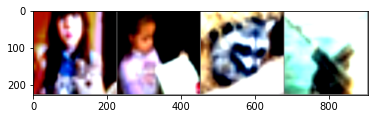

baseball glove baseball glove keyboard oven 


In [7]:
# full_train_dataset.classes
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Question 4 (20 points)

Next, create a ResNet-50 model with pretrained weights from ImageNet using the [torchvision ResNet class](https://pytorch.org/vision/stable/models.html#id10).
Remove the classification layer and replace it with a layer appropriate for identification in CIFAR100. Show that your resulting model can process a minibatch
from your validation dataloader and output (incorrect) identities.

In [8]:
# Code to create a ResNet 50 model, remove classification layer, replace with a CIFAR100 identity layer, and run in evaluation model on a validation minibatch
#%% Blottleneck Block
class BottleneckBlock(nn.Module):
    '''
    BottleneckBlock: More powerful residual block with three convs, used for Resnet50 and up
    '''
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        # If the output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
#         self.is_debug = False
        self.in_planes = 64
        # Initial convolution
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(3, stride = 2, padding = 1)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
#         if self.is_debug : print(f'conv1: {out.shape}')
        out = self.maxpool(out)
#         if self.is_debug : print(f'max pool: {out.shape}')
        out = self.layer1(out)
#         if self.is_debug : print(f'conv2_x: {out.shape}')
        out = self.layer2(out)
#         if self.is_debug : print(f'conv3_x: {out.shape}')
        out = self.layer3(out)
#         if self.is_debug : print(f'conv4_x: {out.shape}')
        out = self.layer4(out)
#         if self.is_debug : print(f'conv5_x: {out.shape}')
        out = self.avgpool(out)
#         if self.is_debug : print(f'avg pool: {out.shape}')
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet50(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of three convolutions each: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1
    Total layers: 1+48+1 = 50
    '''
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)



## Question 5 (20 points)

Next, write a training function, create an optimizer and loss function, and show training loss and validation loss for one epoch.

Show the new ouptut identities for the validation minibatch used in Question 4.

In [9]:
# # Code for training, optimizer, loss here, training one epoch, and new result on validation minibatch

# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
#     print('====================== New Run =======================',file=open("output.txt", "a"))
#     '''
#     train_model: train a model on a dataset
    
#             Parameters:
#                     model: Pytorch model
#                     dataloaders: dataset
#                     criterion: loss function
#                     optimizer: update weights function
#                     num_epochs: number of epochs
#                     weights_name: file name to save weights
#                     is_inception: The model is inception net (Google LeNet) or not

#             Returns:
#                     model: Best model from evaluation result
#                     val_acc_history: evaluation accuracy history
#                     loss_acc_history: loss value history
#     '''
#     since = time.time()

#     val_acc_history = []
#     loss_acc_history = []

#     best_model_wts = deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         epoch_start = time.time()
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1), file=open("output.txt", "a"))
#         print('-' * 10, file=open("output.txt", "a"))

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 # for process anything, device and dataset must put in the same place.
#                 # If the model is in GPU, input and output must set to GPU
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 # it uses for update training weights
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     # Get model outputs and calculate loss
#                     # Special case for inception because in training it has an auxiliary output. In train
#                     #   mode we calculate the loss by summing the final output and the auxiliary output
#                     #   but in testing we only consider the final output.
#                     if is_inception and phase == 'train':
#                         # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
#                         outputs, aux_outputs = model(inputs)
#                         # print('outputs', outputs)
#                         loss1 = criterion(outputs, labels)
#                         loss2 = criterion(aux_outputs, labels)
#                         loss = loss1 + 0.4*loss2
#                     else:
#                         outputs = model(inputs)
#                         loss = criterion(outputs, labels)

#                     _, preds = torch.max(outputs, 1)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
#             epoch_end = time.time()
            
#             elapsed_epoch = epoch_end - epoch_start

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), file=open("output.txt", "a"))
#             print(f"Epoch time taken: {elapsed_epoch}", file=open("output.txt", "a"))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = deepcopy(model.state_dict())
#                 torch.save(model.state_dict(), weights_name + ".pth")
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)
#             if phase == 'train':
#                 loss_acc_history.append(epoch_loss)

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history, loss_acc_history

# resnet = ResNet50().to(device)
# # number of trainable parameters
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f'number of trainable parameters: {count_parameters(resnet)}')

# # Optimizer and loss function
# criterion = nn.CrossEntropyLoss().to(device)
# params_to_update = resnet.parameters()
# # Now we'll use Adam optimization
# #optimizer = optim.SGD(params_to_update, lr=0.01, weight_decay = 1e-4, momentum = 0.9)
# optimizer = optim.Adam(params_to_update, lr=0.01)
# #%% Run
# #resnet.is_debug = True
# best_model, val_acc_history, loss_acc_history = train_model(resnet, dataloaders, criterion, optimizer, 5, 'resnet50_bestsofar')

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model: train a model on a dataset
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # for process anything, device and dataset must put in the same place.
                # If the model is in GPU, input and output must set to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # it uses for update training weights
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        # print('outputs', outputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
                
            loss = criterion(predictions, labels.long())
            
            predictions = nn.functional.softmax(predictions, dim=1)            
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
                       
            predicteds.append(predicted)
            trues.append(labels)            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

resnet = ResNet50().to(device)
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()
# Now we'll use Adam optimization
optimizer = optim.Adam(params_to_update, lr=0.01)

best_model, val_acc_history, loss_acc_history = train_model(resnet, dataloaders, criterion, optimizer, 1, 'resnet50_bestsofar')

Epoch 0/0
----------


/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
# results_resnet50 = open("output.txt", "r")
# print(results_resnet50.read())

## Question 6 (10 points)

Explain how you could use the model you just created as a classifier model in a Control GAN.

*Put your explanation here.*